In [66]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = { # thresh=0.1
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}
du_s7 = {# Centered at y0=y_c, from vel_diff notebook
0.2:[0.487473327013,0.0830669730333],
#0.2:[0.252239340357,0.0314378986591],
0.8:[0.196498053737,0.0143538269484],
2.0:[0.150669226645,0.0373191933283],
}

directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*pstrain12*dat")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_pstrain12_0000.dat', 'shearlayer_pstrain12_0001.dat', 'shearlayer_pstrain12_0003.dat', 'shearlayer_pstrain12_0004.dat', 'shearlayer_pstrain12_0005.dat', 'shearlayer_pstrain12_0012.dat', 'shearlayer_pstrain12_0013.dat', 'shearlayer_pstrain12_0014.dat', 'shearlayer_pstrain12_0015.dat', 'shearlayer_pstrain12_0016.dat', 'shearlayer_pstrain12_0017.dat', 'shearlayer_pstrain12_0018.dat', 'shearlayer_pstrain12_0019.dat', 'shearlayer_pstrain12_0020.dat', 'shearlayer_pstrain12_0101.dat']


2.0: [0.0,0.0],


(-0.5, 0.5)

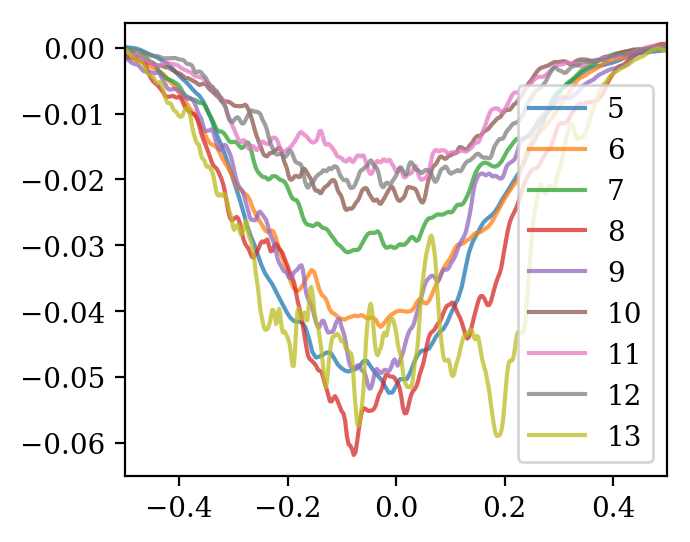

In [51]:
# Scaling using U_delta
s = '7'
if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['20']#['02','08','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


fig = plt.figure(figsize=(3.5,3),dpi=200)
for i,Mc in enumerate(Mc_list):
    if s=='1' and (Mc is '04'):# or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    directory = dir_out
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        
    flist = glob.glob(directory+"*pstrain11*")
    flist.sort()
    flist=flist[:]

#     if Mc=='02': ist=5;ien=10;flist=flist[3:] # mira run
#     #if Mc=='02': ist=-7;ien=-4 # theta run
#     #elif Mc=='04': ist=8;ien=14 #mira run
#     elif Mc=='04': ist=11;ien=-5 #theta run
#     elif Mc=='08': ist=4;ien=-2
#     elif Mc=='12': ist=6;ien=None
#     elif Mc=='16': ist=4;ien=None
#     elif Mc=='20': ist=7;ien=-2
#     else: ist=0; ien=None 
#     if Mc=='02': ist=5;ien=9;flist=flist[2:] # mira run
#     #if Mc=='02': ist=-8;ien=-4 # theta run
#     #elif Mc=='04': ist=8;ien=14 #mira run
#     elif Mc=='04': ist=-9;ien=-5 #theta run
#     elif Mc=='08': ist=9;ien=-1
#     elif Mc=='12': ist=5;ien=-2
#     elif Mc=='16': ist=3;ien=None
#     elif Mc=='20': ist=6;ien=-3;
#     else: ist=0; ien=None 
        
    if s=='7':
        if Mc=='02': ist=15;ien=None
        elif Mc=='08': ist=3;ien=None
        elif Mc=='20': ist=5;ien=None
        
    colorVal = scalarMap.to_rgba(inp.Mc)
    mat = np.zeros([2,len(flist)])
    for j,fname in enumerate(flist[ist:ien]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)
       
        # Get L99
        utilde = np.fromfile(directory+'shearlayer_utilde_%04d.dat'%tID,sep=' ')
        L99,i1,i2 = get_L99(-y,utilde)
        ic = np.argmin(abs(utilde))
        eta=(y-y[ic])/L99

        # Get pstrain
        Pi11 = np.fromfile(fname,sep=' ')
        
        # Get utilde and dudy
        scaling='udelta3'
        if scaling=='du3':
            utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
            L99,i1,i2 = get_L99(-y,utilde)
            scale = L99/inp.du**3
        elif scaling=='udelta3':
            # Get lscale y
            autocorr = np.fromfile(directory+'/lscale_vv_%04d.dat'%(tID),sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.1)
            scale = ly/(du[inp.Mc][0]*inp.du)**3
        fplot = Pi11*scale 
        if 0: pass#j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
        else: plt.plot(-eta,fplot,alpha=0.75,label=tID)#,color=colorVal)#label='%s'%fname)#
        #mat[j] = abs(1./dtheta * integrate_y(y,fplot))
        #mat[0,j] = time*inp.du
        #mat[1,j] = abs(1./dtheta * integrate_y(y,fplot))
    isort = np.argsort(mat[0,:])
    mat[0,:] = mat[0,isort]
    mat[1,:] = mat[1,isort]
    #plt.plot(mat[0,1:]-mat[0,0],mat[1,1:],'-o',alpha=0.25,color=colorVal)
    #plt.plot(mat[0,ist:ien]-mat[0,0],mat[1,ist:ien],'-o',color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
    print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))

plt.legend(fontsize=10)
plt.xlim([-0.5,0.5])

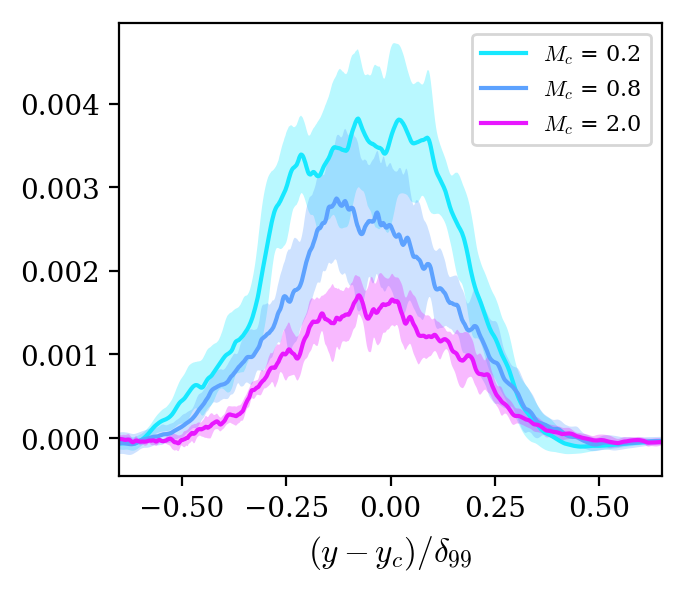

In [72]:
s = '7'
if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


fig = plt.figure(figsize=(3.5,3),dpi=200)
for i,Mc in enumerate(Mc_list):
    if Mc is '04':# or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    directory = dir_out
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        
    flist = glob.glob(directory+"*pstrain22*")
    flist.sort()

    if s=='7':
        if Mc=='02': ist=15;ien=None
        elif Mc=='08': ist=3;ien=None
        elif Mc=='20': ist=5;ien=None

            
    # eta_plot to interpolate onto
    eta_plot = np.linspace(-1.5,1.5,Ny)
    dat_plot = np.zeros([len(flist[ist:ien]),Ny])
    colorVal = scalarMap.to_rgba(inp.Mc)
    for j,fname in enumerate(flist[ist:ien]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)
            
        # Get L99
        utilde = np.fromfile(directory+'shearlayer_utilde_%04d.dat'%tID,sep=' ')
        L99,i1,i2 = get_L99(-y,utilde)
        ic = np.argmin(abs(utilde))
        eta=(y-y[ic])/L99

        scaling='du3'
        if scaling=='du3':
            scale = L99/inp.du**3
        elif scaling=='udelta3':
            autocorr = np.fromfile(directory+'/lscale_vv_%04d.dat'%(tID),sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.1)
            if s=='1': scale = ly/(du[inp.Mc][0]*inp.du)**3
            if s=='7': scale = ly/(du_s7[inp.Mc][0]*inp.du)**3
        # Get pstrain
        dat = np.fromfile(fname,sep=' ')
        fplot = dat*scale 
        
        # Interpolate onto eta_plot
        dat_plot[j,:] = 1*(np.interp(eta_plot,eta,fplot))

    means = np.squeeze(np.mean(dat_plot,axis=0))
    stdev = np.squeeze(np.std(dat_plot,axis=0))
    plt.plot(-eta_plot,means,alpha=1,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
    plt.fill_between(-eta_plot, means-stdev, means+stdev ,alpha=0.3, facecolor=colorVal)
        
        
    plt.xlim([-0.65,0.65])
    plt.xlabel(r'$(y-y_c)/\delta_{99}$')
    plt.legend()

Text(0.5,0,'$M_c$')

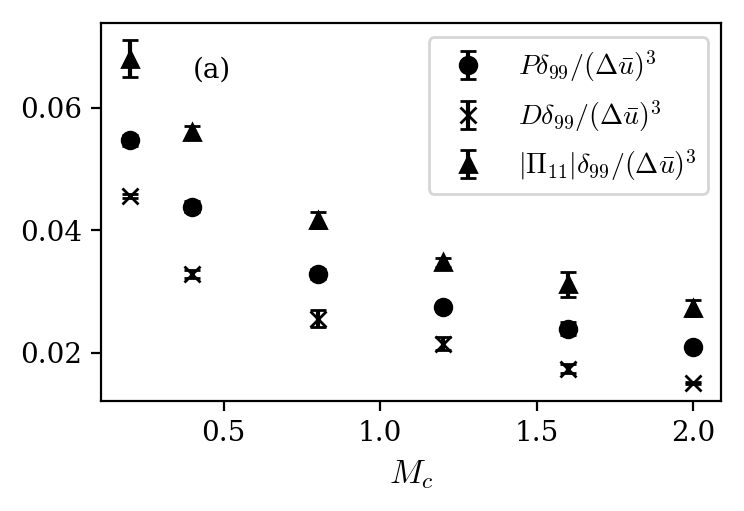

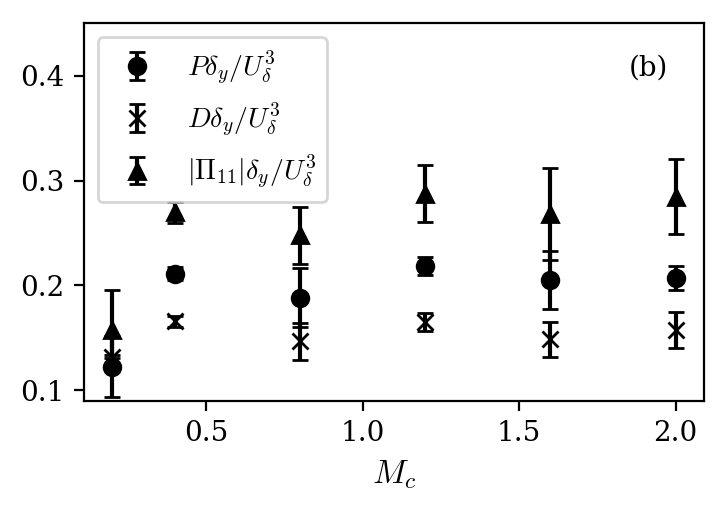

In [11]:
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

def plotter_v2(ax,dat,fmt,label,colorVal='k'):
    Mcs = []
    vals = []
    errs = []
    for Mc in sorted(dat.keys()):
        Mcs.append( Mc )
        vals.append( dat[Mc][0] )
        errs.append( dat[Mc][1] )
    plt.errorbar(Mcs,vals,color=colorVal,yerr=errs,fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(4,2.5),dpi=200)
plotter(Pii['du3'],'ko',r'$P\delta_{99}/(\Delta\bar{u})^3$')
plotter(Dii['du3'],'kx',r'$D\delta_{99}/(\Delta\bar{u})^3$')
plotter(pi11['du3'],'k^',r'$|\Pi_{11}|\delta_{99}/(\Delta\bar{u})^3$')
plt.annotate('(a)',(0.4,0.065),fontsize=10)
plt.legend(fontsize=10)
plt.xlabel(r'$M_c$')

fig = plt.figure(figsize=(4,2.5),dpi=200)
plotter(Pii['udelta3'],'ko',r'$P\delta_{y}/U_\delta^3$')
plotter(Dii['udelta3'],'kx',r'$D\delta_{y}/U_\delta^3$')
plotter(pi11['udelta3'],'k^',r'$|\Pi_{11}|\delta_{y}/U_\delta^3$')
plt.annotate('(b)',(1.85,0.4),fontsize=10);plt.ylim([0.09,0.45])
plt.legend(fontsize=10)#,bbox_to_anchor=(0.1,0.75))
plt.xlabel(r'$M_c$')



In [ ]:
# Production
% plotted: P * L99/dtheta/dU^3
% Vreman: 2/rho/dU^2 * P = rate
% P = rate*dU^2*rho/2
% P * L99/dtheta/dU^3 = (rate*dU^2*rho/2) * L99/dtheta/dU^3
% P * L99/dtheta/dU^3 = rate*rho/2 * L99/dtheta/dU

In [6]:
Pii = {} # P = R12*dudy
Pii['du3'] = {
0.2: [0.0546923595943,0.000895872694489],
0.4: [0.0438481452556,0.000913229516588],
0.8: [0.0328301743182,0.000812241701633],
1.2: [0.0274991290777,0.000507569207411],
1.6: [0.0239129034,0.00108117790097],
2.0: [0.0208812017414,0.000297399722035],
}
Pii['udelta3'] = {
0.2: [0.122518619095,0.028868538236],
0.4: [0.211269887525,0.00640637180369],
0.8: [0.188443401767,0.0278830777178],
1.2: [0.218497559511,0.00855344046322],
1.6: [0.205110308217,0.027979163661],
2.0: [0.207098877612,0.0116296335157],
}

# P12 = {} # Need to recompute with floatpy P12 = R12*dvdy + R22*dudy
# P12['du3'] = {
# 0.2: [0.0147938322437,0.000320648208723],
# 0.4: [0.0117727463504,0.000169072207823],
# 0.8: [0.00893065223876,0.000298407365872],
# 1.2: [0.00781210407393,0.000285157487984],
# 1.6: [0.00725509813651,0.000175906508695],
# 2.0: [0.00694478528564,0.000148471177762],
# }
# P12['udelta3'] = {
# 0.2: [0.0367294692995,0.00554230749857],
# 0.4: [0.0557491476332,0.00188244271159],
# 0.8: [0.055847989462,0.00706263001989],
# 1.2: [0.0653397734325,0.0065778082747],
# 1.6: [0.0603573763066,0.00693851773739],
# 2.0: [0.0677701092893,0.0038638398553],
# }
Dii = {}
Dii['du3'] = {
0.2: [0.0455178267898,0.000317096484502],
0.4: [0.0328185595585,0.000583054404613],
0.8: [0.0255385454801,0.00138048210775],
1.2: [0.0214715926908,0.00110294359056],
1.6: [0.0173707264304,0.000705057583086],
2.0: [0.0150954087775,0.000171882724051],
}
Dii['udelta3'] = {
0.2: [0.132044888023,0.00120058057481],
0.4: [0.165709454376,0.00545376254762],
0.8: [0.146540621338,0.0175145174641],
1.2: [0.165077784106,0.0084372244007],
1.6: [0.148600482215,0.0169581207998],
2.0: [0.157537529254,0.0175434893373],
}

D12 = {}
D12['du3'] = {
0.2: [0.00348451365828,8.29147773734e-05],
0.4: [0.00289011838053,4.55132895405e-05],
0.8: [0.00253759974366,7.40926250144e-05],
1.2: [0.00209200474934,4.60202864009e-05],
1.6: [0.0017446833596,0.000123853682594],
2.0: [0.00157604514984,5.54608616482e-05],
}
D12['udelta3'] = {
0.2: [0.0133430115565,0.000126950742741],
0.4: [0.0160822974536,0.000461520087589],
0.8: [0.0156440508158,0.00168759752086],
1.2: [0.0168683757588,0.000689802772831],
1.6: [0.0151483062263,0.00177141509917],
2.0: [0.0164836036851,0.00223140238714],
}

pi12={}
pi12['du3']={
0.2: [0.0765033115064,0.00376905219816],
0.4: [0.0646598330569,0.0012037446949],
0.8: [0.0477863624911,0.00328183656648],
1.2: [0.0395687264513,0.00203396180632],
1.6: [0.0319019733976,0.00166472901232],
2.0: [0.0278097830711,0.00117017397839],
}
pi12['udelta3']={
0.2: [0.177224865062,0.0405302074524],
0.4: [0.315054274648,0.0104115250522],
0.8: [0.284747181712,0.0404897588568],
1.2: [0.318062722926,0.0266553266386],
1.6: [0.273434895243,0.0363298328627],
2.0: [0.289340954435,0.0246966512005],
}
# for k in pi12['du3']: 
#     pi12['du3'][k][0]*=0.1
#     pi12['du3'][k][1]*=0.1
    
pi11={} 
pi11['du3']={
0.2: [0.0679777549377,0.00300496161409],
0.4: [0.0559659224077,0.00101023687655],
0.8: [0.0416280210657,0.00129022627497],
1.2: [0.034752577764,0.000764817572567],
1.6: [0.0311546126208,0.00207805265242],
2.0: [0.0272639977608,0.00135347163208],
}
pi11['udelta3']={
0.2: [0.157944196646,0.0373935152883],
0.4: [0.269723743494,0.00976011084104],
0.8: [0.247615533441,0.0275975540002],
1.2: [0.287648148543,0.0271184153566],
1.6: [0.267840808709,0.0436957303587],
2.0: [0.284598768654,0.0356884036278],
}
